In [1]:
import numpy as np
from netCDF4 import Dataset
import os
from matplotlib import pyplot as plt
import matplotlib as mpl
plt.ion()

In [2]:

mpl.rcParams['image.cmap'] = 'RdBu_r'
mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.interpolation'] = 'nearest'


In [5]:
exp = 'turb2d_forced_ss'
ncfile = os.getenv("HOME")+'/data/fluid2d/{0}/{0}_his.nc'.format(exp)
print(ncfile)

/Users/gula/data/fluid2d/turb2d_forced_ss/turb2d_forced_ss_his.nc


In [6]:
with Dataset(ncfile) as nc:
    psi = nc['psi'][:, :, :]
    vor = nc['vorticity'][:, :, :]
    time = nc['t'][:]
    x = nc['x'][:]
    y = nc['y'][:]

In [7]:
def spec2d(nx, kk, phi, alpha=0):
    hphi = np.abs(np.fft.fft2(phi))**2
    if alpha>0:
        hphi *= kk**alpha
    spec = np.zeros((nx//2,))
    for i in range(nx//2):
        spec[i] = np.sum(hphi[(kk>=i) & (kk<(i+1))])
    return spec

def set_x_and_k(n, L):
    k = ((n//2+np.arange(n)) % n) - n//2
    return (np.arange(n)+0.5)*L/n, 2*np.pi*k/L

ny, nx = np.shape(psi[0])
_, kx = set_x_and_k(nx, 2*np.pi)
_, ky = set_x_and_k(ny, 2*np.pi)
kkx, kky = np.meshgrid(kx, ky)
kk = np.sqrt(kkx**2 + kky**2)


In the cell below we generate a random field with a very peaked power spectrum density (peak at $k_0$, width $dk$). The field has a white noise random phase and a gaussian distribution in $k$.

This how the initial conditions and the forcing are generated in the Fluid2d scripts

Text(0, 0.5, 'p.s.d.')

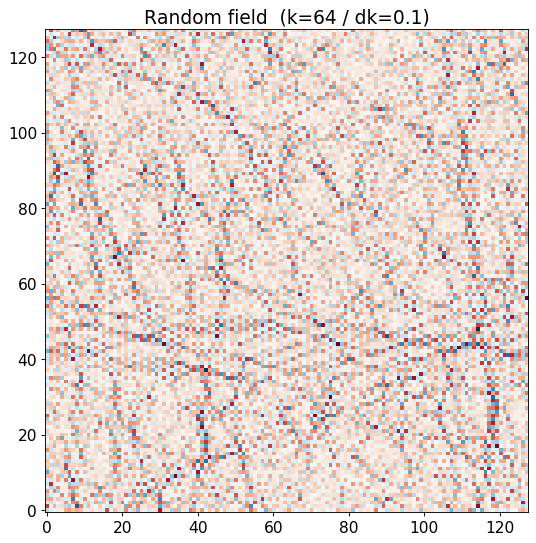

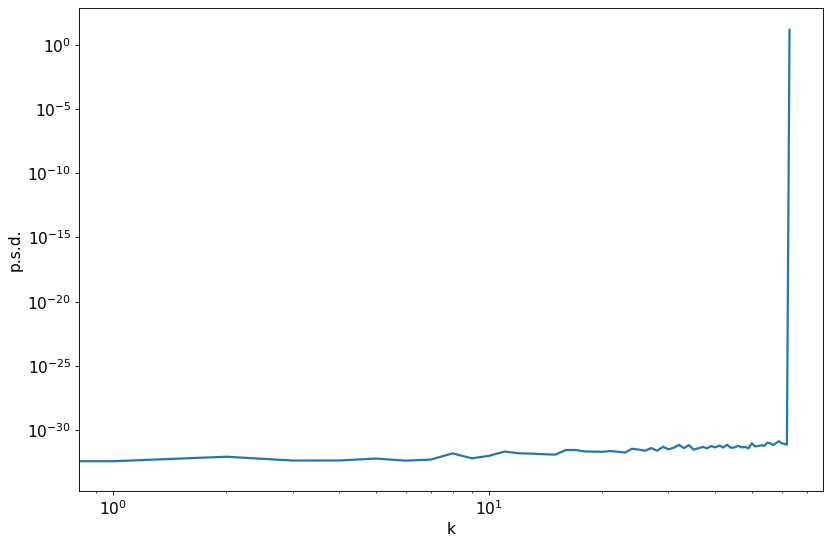

In [8]:
# change these values and observe the resulting random field
k0 = nx//2  # peak
dk = .1  # width

# white noise phase
phase = np.random.normal(size=(ny, nx))*2*np.pi
# gaussian distribution
hnoise = np.exp(-(kk-k0)**2/(2*dk**2))*np.exp(1j*phase)
noise = np.real(np.fft.ifft2(hnoise))
plt.imshow(noise, origin='xy')
plt.title('Random field  (k=%.0f / dk=%.1f)' % (k0, dk))
plt.figure()
h = spec2d(nx, kk, noise)
plt.loglog(h)
plt.xlabel('k')
plt.ylabel('p.s.d.')

Text(0, 0.5, 'P.S.D.')

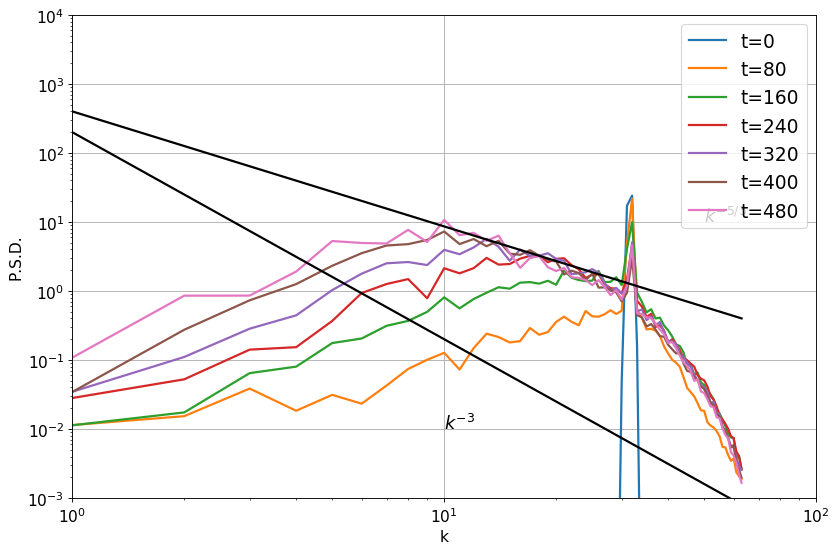

In [9]:
# let's plot the Kinetic Energy spectrum
# in Fourier space KE = k^2 |psi|^2 * 0.5
# because |u| = k |psi|
plt.figure(figsize=(12,8))
for k, t in enumerate(time[::4]):
    h = spec2d(nx, kk, psi[k], alpha=2)
    plt.loglog(h, label='t=%.0f' % t)
plt.axis([1, 100, 1e-3, 1e4])
plt.grid()
k = np.arange(1.,nx//2)
plt.plot(k, 2e2 * k**(-3), color='k')
plt.plot(k, 4e2 * k**(-5./3), color='k') # the coefficient set the vertical position of the line
plt.text(50, 10, r'$k^{-5/3}$', fontsize=16)
plt.text(10, .01, r'$k^{-3}$', fontsize=16)
plt.legend()
plt.xlabel('k')
plt.ylabel('P.S.D.')

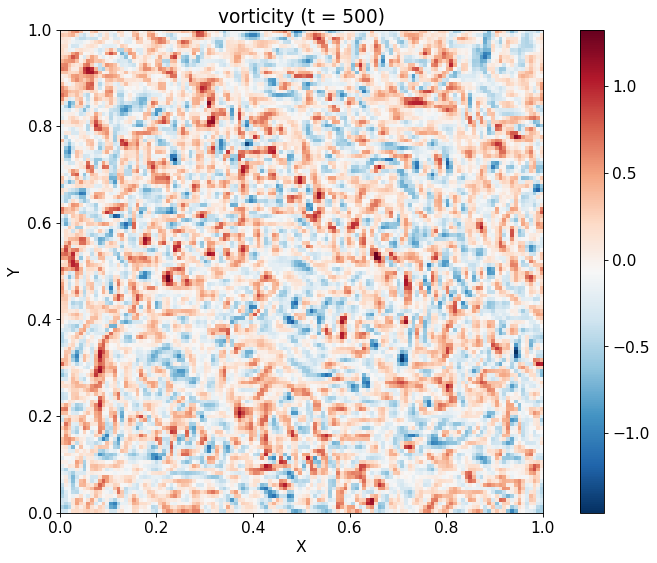

In [11]:
# we plot here a snapshot of vorticity
plt.imshow(vor[-1], origin='xy', interpolation='nearest', extent=[0,1,0,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('vorticity (t = %.0f)' % time[-1])
plt.colorbar()
#plt.savefig('turb2d.png')